# Predicting the NBA Regular Season MVP Winner


## Load data

In [1]:
# import our usual libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint # pretty print

/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# since we have many files, let's create function to read in and name the files
import glob

def importGlobbedFiles(path):
    '''
    This function reads in the csv files in the specified path and concatenates them. 
    This function requires the glob library.
    '''
    globbed_files = glob.glob(path + '/*.csv')
    list_of_dfs = []
    for csv in globbed_files:
        df = pd.read_csv(csv)
        list_of_dfs.append(df)
    return pd.concat(list_of_dfs)

In [3]:
# read in 3 datasets
df_basic_stats = importGlobbedFiles('data_historical_basic_stats')
df_adv_stats = importGlobbedFiles('data_historical_adv_stats')
df_mvp_stats = importGlobbedFiles('data_historical_mvp')
df_team_stats = importGlobbedFiles('data_historical_win_record')

## First pass preprocessing & EDA

In [4]:
# Check out the data: head, describe, info
# df_basic.head()
# df_adv.head()
# df_mvp.head()
# df_basic.info()
# df_team_records.head()

In [5]:
# Create some functions for basic cleaning
def adjustFeatureNames(df):
    '''This function replaces spaces in the columns with whitespace.'''
    df.columns = df.columns.str.lower().str.replace(' ', '_')

def cleanSomeFeatures(df):
    '''This function removes the * found in player name.'''
    if 'player' in df.columns:
        df['player'] = df['player'].str.replace('*','')

In [6]:
list_of_dfs = [df_basic_stats, df_adv_stats, df_mvp_stats, df_team_stats]    

# Clean dataframes in list
for df in list_of_dfs:
    adjustFeatureNames(df)
    cleanSomeFeatures(df)

In [7]:
# Create a dictionary that translates the full team now to the 3-letter initialism
# Note some team names have been deprecated
team_dict = {'Atlanta Hawks':'ATL', 'Boston Celtics':'BOS', 'Brooklyn Nets':'BRK'
           , 'Charlotte Bobcats':'CHA', 'Charlotte Hornets':'CHH', 'Chicago Bulls':'CHI'
           , 'Cleveland Cavaliers':'CLE', 'Dallas Mavericks':'DAL', 'Denver Nuggets':'DEN'
           , 'Detroit Pistons':'DET', 'Golden State Warriors':'GSW', 'Houston Rockets':'HOU'
           , 'Indiana Pacers':'IND', 'Los Angeles Clippers':'LAC', 'Los Angeles Lakers':'LAL'
           , 'Memphis Grizzlies':'MEM', 'Miami Heat':'MIA', 'Milwaukee Bucks':'MIL'
           , 'Minnesota Timberwolves':'MIN', 'New Jersey Nets':'NJN', 'New Orleans Hornets':'NOH'
           , 'New Orleans Pelicans':'NOP', 'New Orleans/Oklahoma City Hornets':'NOK'
           , 'New York Knicks':'NYK', 'Oklahoma City Thunder':'OKC', 'Orlando Magic':'ORL'
           , 'Philadelphia 76ers':'PHI', 'Phoenix Suns':'PHO', 'Portland Trail Blazers':'POR'
           , 'Sacramento Kings':'SAC', 'San Antonio Spurs':'SAS', 'Seattle SuperSonics':'SEA'
           , 'Toronto Raptors':'TOR', 'Utah Jazz':'UTA', 'Vancouver Grizzlies':'VAN'
           , 'Washington Wizards':'WAS'}

# sorted(df_basic['Tm'].unique())

In [8]:
# Create a function to merge the dfs together
def merge_basic_adv(df_basic, df_adv):
    basic_features = ['player', 'tm', 'season_end',  'g', 'gs', 'mp', 'fg', 'fga', 'fg%'
                  , '3p', '3pa', '3p%', '2p', '2pa', '2p%', 'efg%', 'ft', 'fta', 'ft%'
                  , 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
    adv_features = ['player', 'tm', 'season_end', 'per', 'ts%', '3par', 'ftr', 'orb%'
                , 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%', 'ows'
                , 'dws', 'ws', 'ws/48', 'obpm', 'dbpm', 'bpm', 'vorp']
    # Merge basic & adv
    df_combined = df_basic[basic_features].merge(df_adv[adv_features]
                                                  , how='left', on=['player', 'tm', 'season_end'])
    # Fill NaN with 0
    df_combined.fillna(0, inplace=True)
    # Return a dataframe
    return df_combined

def merge_team_stats(df_basic_adv, df_team):
    # Map the team name to its initials
    df_team['tm_name'] = df_team['team'].map(team_dict)
    team_features = ['tm_name', 'season_end', 'win-loss']
    df_combined = df_basic_adv.merge(df_team[team_features], how='left'
                                          , left_on=['tm', 'season_end'], right_on=['tm_name', 'season_end'])
    # Drop the long form team name
    df_combined.drop(columns='tm_name', inplace=True)
    # Fill NaN with 0
    df_combined.fillna(0, inplace=True)
    # Return a dataframe
    return df_combined

def merge_mvp(df_basic_adv_team, df_mvp):
    # Add new feature to signify these players were on the mvp shortlist
    df_mvp['mvp_shortlist'] = 1
    # Add new feature to signify which player in the shortlist won mvp
    df_mvp_winners = df_mvp.groupby('mvp_year').max()[['share']].reset_index()
    df_mvp_winners.insert(2, 'mvp', 1)
    df_mvp_tmp = df_mvp.merge(df_mvp_winners, how='outer', on=['mvp_year', 'share'])
    # Features to keep
    mvp_features = ['player', 'tm', 'mvp_year', 'share', 'mvp_shortlist', 'mvp']
    # merge dfs
    df_combined = df_basic_adv_team.merge(df_mvp_tmp[mvp_features]
                                      , how='left' , left_on=['player', 'tm', 'season_end']
                                      , right_on=['player', 'tm', 'mvp_year'])
    # Fill NaN with 0
    df_combined.fillna(0, inplace=True)
    # Return a dataframe
    return df_combined

In [9]:
# Merge all dataframes
df_all_stats = merge_mvp(merge_team_stats(merge_basic_adv(df_basic_stats, df_adv_stats), df_team_stats), df_mvp_stats)

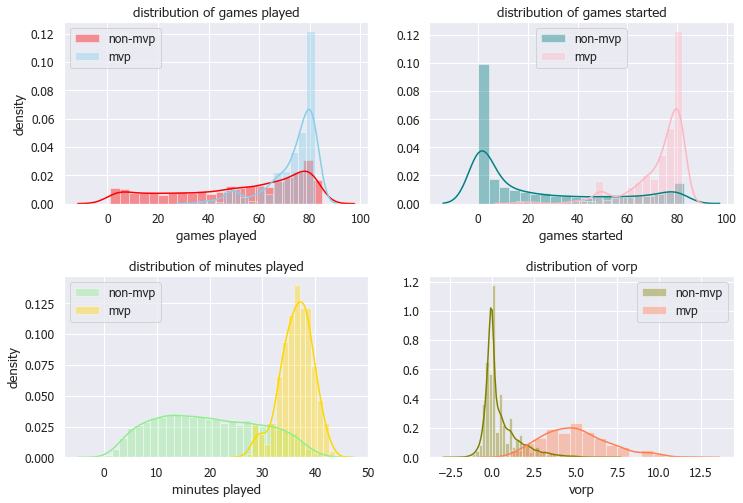

In [10]:
# set style
sns.set(style='darkgrid', font='Tahoma', font_scale=1.1)

# we want to compare the distribution of key attributes of mvp-caliber players and not
mvp_g = np.array(df_all_stats.query('mvp_shortlist == 1')['g'])
mvp_mp = np.array(df_all_stats.query('mvp_shortlist == 1')['mp'])
non_mvp_g = np.array(df_all_stats.query('mvp_shortlist == 0')['g'])
non_mvp_mp = np.array(df_all_stats.query('mvp_shortlist == 0')['mp'])
mvp_gs = np.array(df_all_stats.query('mvp_shortlist == 1')['gs'])
non_mvp_gs = np.array(df_all_stats.query('mvp_shortlist == 0')['gs'])
mvp_vorp = np.array(df_all_stats.query('mvp_shortlist == 1')['vorp'])
non_mvp_vorp = np.array(df_all_stats.query('mvp_shortlist == 0')['vorp'])

fig, axs = plt.subplots(2, 2, figsize=(12,8))
plt.subplots_adjust(hspace=0.4)

# add plot for games played
sns.distplot(non_mvp_g, hist=True, kde = True, color='red', label='non-mvp',  ax=axs[0, 0])
sns.distplot(mvp_g, hist=True, kde=True, color='skyblue', label='mvp',  ax=axs[0, 0])
axs[0,0].set_title('distribution of games played')
axs[0,0].set_xlabel('games played')
# axs[0,0].set_xticks(np.arange(0, 100, step=10))

# add plot for minutes played
sns.distplot(non_mvp_mp, hist=True, kde = True, color='lightgreen', label='non-mvp', ax=axs[1, 0])
sns.distplot(mvp_mp, hist=True, kde=True, color='gold', label='mvp', ax=axs[1, 0])
axs[1,0].set_title('distribution of minutes played')
axs[1,0].set_xlabel('minutes played')
# axs[1,0].set_xticks(np.arange(0, 50, step=5))

# add plot for games started
sns.distplot(non_mvp_gs, hist=True, kde = True, color='teal', label='non-mvp', ax=axs[0,1])
sns.distplot(mvp_gs, hist=True, kde=True, color='lightpink', label='mvp', ax=axs[0,1])
axs[0,1].set_title('distribution of games started')
axs[0,1].set_xlabel('games started')
# axs[0,1].set_xticks(np.arange(0, 100, step=10))

# add plot for vorp
sns.distplot(non_mvp_vorp, hist=True, kde = True, color='olive', label='non-mvp', ax=axs[1,1])
sns.distplot(mvp_vorp, hist=True, kde=True, color='coral', label='mvp', ax=axs[1,1])
axs[1,1].set_title('distribution of vorp')
axs[1,1].set_xlabel('vorp')
# ax4.set_xticks(np.arange(0, 100, step=10))

# Set labels for all graphs
for i in range(2):
    axs[i,0].set_ylabel('density')
    for j in range(2):
        axs[i,j].legend()
        
plt.show();

## Split into train & test sets

At this stage, the final dataframe is ready. Dtypes are appropriate, missing values have been taken care of. The features and target variable have been identified.

- One-hot encoded categorical variables
- Split data into features and labels
- Converted to arrays
- Split data into training and testing sets

In [21]:
# Separate the features and target variable
features = df_all_stats.iloc[:,:-4].reset_index(drop=True) # note the first 2 columns are objects
feature_names = features.columns.to_numpy()
response = df_all_stats.iloc[:,-2:-1].to_numpy().ravel() # this is a 1D array

In [22]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, response, random_state=14
                                                    , test_size = 0.25, stratify=response)

print('shape of training set features: ', X_train.shape)
print('shape of target variable: ', y_train.shape)
print('shape of test set features: ', X_test.shape)
print('shape of target variable: ', y_test.shape)

shape of training set features:  (7644, 49)
shape of target variable:  (7644,)
shape of test set features:  (2548, 49)
shape of target variable:  (2548,)


### Baseline accuracy (null accuracy)

In [23]:
# This is the accuracy if we guessed '0' for every instance
mvp_shortlist_count = np.count_nonzero(response == 1)
count = len(response)
print(f'count (mvp shortlist count, total count): {mvp_shortlist_count}, {count}')
print('baseline accuracy in all data: {:.2%}'.format(1-mvp_shortlist_count/count))

train_mvp_shortlist_count = np.count_nonzero(y_train)
train_count = len(y_train)
print(f'count (mvp shortlist count, train count): {train_mvp_shortlist_count}, {train_count}')
print('baseline accuracy in train set: {:.2%}'.format(1-train_mvp_shortlist_count/train_count))

test_mvp_shortlist_count = np.count_nonzero(y_test)
test_count = len(y_test)
print(f'count of (mvp shortlist count, test count): {test_mvp_shortlist_count}, {test_count}')
print('baseline accuracy in test set: {:.2%}'.format(1-test_mvp_shortlist_count/test_count))

count (mvp shortlist count, total count): 327, 10192
baseline accuracy in all data: 96.79%
count (mvp shortlist count, train count): 245, 7644
baseline accuracy in train set: 96.79%
count of (mvp shortlist count, test count): 82, 2548
baseline accuracy in test set: 96.78%


## Prepare the data for machine learning

Feature scaling, feature selection, feature extraction (if applicable)

###  Feature scaling

Normalize or standardize data.
- min-max scaling/normalization = x-min/(max-min) <- value between (0,1)
- standardization = x-mean/sd <- standardized values always have 0 mean. less affected by outliers.

In [128]:
# Separate the identifying information and numerical stats
X_train_identifiers = X_train.iloc[:,:3]
X_train_num = X_train.iloc[:,3:]
X_train_features = X_train_num.columns.to_numpy()
X_test_identifiers = X_test.iloc[:,:3]
X_test_num = X_test.iloc[:,3:]
X_test_features = X_test_num.columns.to_numpy()

# We will normalize our numeric features
from sklearn.preprocessing import MinMaxScaler

# Instantiate the scaler
scaler = MinMaxScaler()

# Fit the trained features
X_train_num = scaler.fit_transform(X_train_num)
X_train_num = pd.DataFrame(data=X_train_num, columns=X_train_features)

# Fit the test features with the scaler trained with the training features
X_test_num = scaler.transform(X_test_num)
X_test_num = pd.DataFrame(data=X_test_num, columns=X_test_features)

### Feature selection (if applicable)

Which features are best? Choose only a few to avoid overfitting and the curse of dimensionality.

We use several methods here:
- univariate feature selection: in this case, the ANOVA F-value
- recursive feature elimination (RFE)
- feature importance from decision trees classifier
- ridge regression


In [25]:
# function to return unique pairs, not including self-pairs
def get_unique_pairs(df):
    list_of_pairs = []
    for i in df.corr().columns:
        for j in df.corr().columns:
            if i == j:
                continue
            else:
                list_of_pairs.append((i, j))
    return set(tuple(sorted(i)) for i in list_of_pairs)

# function to return pairs & correlation as a series
def get_pairwise_corrs(df, n=10):
    corr_unstacked = df.corr().abs().unstack()
    pw_corrs = corr_unstacked.filter(items=get_unique_pairs(df), axis=0).sort_values(ascending=False)
    return pw_corrs[0:n]

In [26]:
# get_pairwise_corrs(X_train_num)

In [27]:
# Based on correlations, we should drop:
drop_cols = ['2p', '2pa', '3pa', 'ast%', 'blk%', 'bpm', 'drb', 'drb%', 'efg%', 'fg'
             , 'fg%', 'fga', 'ft', 'fta', 'obpm', 'orb', 'orb%', 'ows', 'ws']

# Drop columns above
X_train_num = X_train_num.drop(columns=drop_cols)
X_train_num_names = X_train_num.columns.values 

Now that we've dropped a few columns by way of pairwise correlations, let's use some wrapper methods.

In [28]:
# Univariate feature selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# ANOVA F-statistic
selector_f = SelectKBest(score_func=f_classif, k=6)
selector_f.fit(X_train_num, y_train)
# print('F-value scores: ', selector.scores_)
print('ANOVA feature names: ', X_train_num_names[selector_f.get_support(indices=True)])

# Chi2 score
selector_chi = SelectKBest(score_func=chi2, k=6)
selector_chi.fit(X_train_num, y_train)
print('Chi2 feature names: ', X_train_num_names[selector_chi.get_support(indices=True)])

ANOVA feature names:  ['ast' 'tov' 'pts' 'usg%' 'dws' 'vorp']
Chi2 feature names:  ['gs' 'ast' 'tov' 'pts' 'dws' 'vorp']


In [29]:
# recursive feature elimination. chose Random Forest Classifier, but can use other estimators
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=500)
rfe = RFE(estimator, n_features_to_select=6, step=1)
rfe.fit(X_train_num, y_train)

print('Feature ranking: ', rfe.ranking_)
# print('Feature index ranked #1: ', rfe.get_support(indices=True))
print('Feature names: ', X_train_num_names[rfe.get_support(indices=True)])

Feature ranking:  [17  8  3 22 20 16 10  6  5 15 19  1 12  1  1  9 18 14 11 21 13  4  2  1
  7  1  1]
Feature names:  ['tov' 'pts' 'per' 'ws/48' 'vorp' 'win-loss']


In [30]:
# Feature importance using ensemble learning
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=500)
estimator.fit(X_train_num, y_train)
important_features = np.round(estimator.feature_importances_, 3)
print('sorted by important features: ')
print(sorted(zip(important_features, X_train_num_names), reverse=True)[0:6])

sorted by important features: 
[(0.166, 'vorp'), (0.118, 'per'), (0.11, 'pts'), (0.078, 'ws/48'), (0.052, 'usg%'), (0.051, 'dws')]


Now, we should have identified a subset of features that we will use in the machine learning model.

In [31]:
# We choose to include only these features in our machine learning:
selected_features = ['vorp', 'per', 'ws/48', 'pts', 'win-loss', 'tov']

# Modifying our training and test sets for machine learning
X_train_ML = X_train_num[selected_features]
X_test_ML = X_test_num[selected_features]

## Train a model

Train & evaluate on the training set.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [33]:
def show_scores(clf, X, y_true, name='insert classifier name'):
    y_pred = clf.predict(X)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return name, accuracy, precision, recall, f1

In [34]:
list_of_scores = []

# Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=2000)
logreg.fit(X_train_ML, y_train)
list_of_scores.append(show_scores(logreg, X_train_ML, y_train, 'logistic regression'))

# Random Forest
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_ML, y_train)
list_of_scores.append(show_scores(rf, X_train_ML, y_train, 'random forest'))

# SVC
svc = SVC(gamma='scale', probability=True)
svc.fit(X_train_ML, y_train)
list_of_scores.append(show_scores(svc, X_train_ML, y_train, 'support vector machines'))

# KNN
knn = KNeighborsClassifier()
knn.fit(X_train_ML, y_train)
list_of_scores.append(show_scores(knn, X_train_ML, y_train, 'k nearest neighbors'))

# Gaussian Naive Bayes
gauss = GaussianNB()
gauss.fit(X_train_ML, y_train)
list_of_scores.append(show_scores(gauss, X_train_ML, y_train, 'gaussian naive bayes'))

# Perceptron
perceptron = Perceptron()
perceptron.fit(X_train_ML, y_train)
list_of_scores.append(show_scores(perceptron, X_train_ML, y_train, 'perceptron'))

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_ML, y_train)
list_of_scores.append(show_scores(lda, X_train_ML, y_train, 'lda'))

In [35]:
# Create dataframe of scores
df_scores = pd.DataFrame(data=list_of_scores, 
             columns=['estimator', 'accuracy', 'precision', 'recall', 'f1']).set_index('estimator')

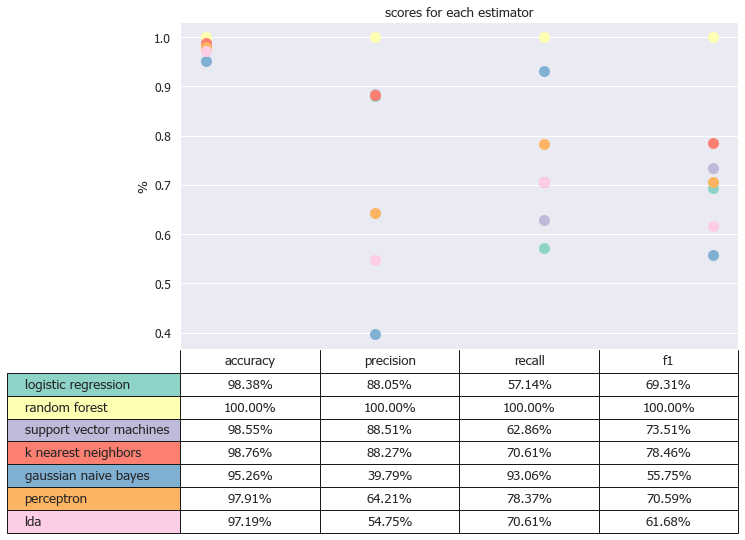

In [37]:
# Set up data
data = df_scores.values # array in float
columns = df_scores.columns
rows = df_scores.index.values

# Establish figure
fig, ax = plt.subplots(figsize=(10,6))

# Establish colormap
colormap = plt.cm.Set3(np.linspace(0, 0.6, len(rows)))

# Initialize the vertical-offset for the stacked bar chart
# y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
for i in range(len(data)): # len(data)=8
    ax.scatter(columns, data[i], color=colormap[i], linewidths=5)
#     y_offset = y_offset + data[row]

ax.set_ylabel('%')
ax.set_xticks([]) # [] disables xticks
ax.set_title('scores for each estimator')

# Add a table at the bottom of the axes
table = ax.table(cellText=df_scores.applymap(lambda x: '{:.2%}'.format(x)).values
                  , cellLoc='center', rowLabels=rows, rowColours=colormap
                  , colLabels=columns, loc='bottom')

# Adjust the table row heights
for i in range(1,len(rows)+1):
    table[i,-1].set_height(.07)
    table[i,-1].set_verticalalignment = 'center'

for i in range(len(columns)):
    table[0,i].set_height(.075)
    for j in range(1,len(rows)+1):
        table[j,i].set_height(.07)
        table[j,i].set_verticalalignment='center'
        
plt.show();

## Train a model using k-fold cross validation
RF, SVC, and KNN look pretty good.

In [38]:
from sklearn.model_selection import cross_val_score

# Create function to show all cross-validation scores
def show_cv_scores(fitted_clf, X, y_true, cv=5, name='insert classifier name'):
    accuracy = cross_val_score(fitted_clf, X, y_true, cv=cv, scoring='accuracy')
    precision = cross_val_score(fitted_clf, X, y_true, cv=cv, scoring='precision')
    recall = cross_val_score(fitted_clf, X, y_true, cv=cv, scoring='recall')
    f1 = cross_val_score(fitted_clf, X, y_true, cv=cv, scoring='f1')
    return name, accuracy.mean(), precision.mean(), recall.mean(), f1.mean()

In [39]:
list_of_cv_scores = [show_cv_scores(logreg, X_train_ML, y_train, cv=5, name='logistics regression')
                     , show_cv_scores(rf, X_train_ML, y_train, cv=5, name='random forest')
                     , show_cv_scores(svc, X_train_ML, y_train, cv=5, name='svc')
                     , show_cv_scores(knn, X_train_ML, y_train, cv=5, name='knn')]

In [40]:
df_cv_scores = pd.DataFrame(data=list_of_cv_scores
                            , columns=['estimator', 'accuracy', 'precision', 'recall', 'f1']).set_index('estimator')
df_cv_scores

,accuracy,precision,recall,f1
estimator,,,,
logistics regression,0.983517,0.884624,0.559184,0.684373
random forest,0.983778,0.819399,0.628571,0.705990
svc,0.984825,0.879469,0.612245,0.720737
knn,0.983386,0.817266,0.620408,0.704994


Now we should have a shortlist of promising models. We are looking for the ones that maximize high precision. Let's fine tune them by adjusting their hyperparameters: logistic regression and random forest.

## Fine tune the model hyperparameters

- grid search vs. randomized search
- ensemble methods

We choose SVC and logistic regression.

In [41]:
from pprint import pprint
print('SVC parameters parameters:')
pprint(svc.get_params())

SVC parameters parameters:
{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [44]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter selections
kernel = ['linear', 'rbf']
gamma = ['scale', 'auto']
C = [0.1, 1, 10]
degree = [2, 3, 4, 5, 6]

# Create the random grid
hyperparameters = {'C': C, 'degree': degree, 'gamma': gamma, 'kernel': kernel}

In [45]:
# Use the random grid to search for best hyperparameters
svc_random = RandomizedSearchCV(estimator=svc, param_distributions=hyperparameters
                                , n_iter=100, scoring='precision', n_jobs=-1, cv=5
                                , verbose=2, random_state=42)
# Fit the random search model
svc_random.fit(X_train_ML, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.1s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='scale', kernel='rbf',
                                 max_iter=-1, probability=True,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'degree': [2, 3, 4, 5, 6],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='precision', verbose=2)

In [46]:
# Show the best parameters
svc_random.best_params_

{'kernel': 'linear', 'gamma': 'scale', 'degree': 2, 'C': 0.1}

In [47]:
print('Logistic regression parameters:')
pprint(logreg.get_params())

Logistic regression parameters:
{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 2000,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [70]:
#
penalty = ['l2', 'none']
C = [0.1, 1, 10]
solver = ['lbfgs'] # only 2 out of 4

# Create the random grid
hyperparameters = {'solver': solver, 'C': C, 'penalty': penalty}

In [71]:
# Use the random grid to search for best hyperparameters
logreg_random = RandomizedSearchCV(estimator=logreg, param_distributions=hyperparameters
                                   , n_iter=100, scoring='precision', n_jobs=-1, cv=5
                                   , verbose=2, random_state=42)
# Fit the random search model
logreg_random.fit(X_train_ML, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.0s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=2000,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'penalty': ['l2', 'none'],
                                        'solver': ['lbfgs']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
          

In [72]:
logreg_random.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Evaluate on test set

In [74]:
# Evaluate with the best model from random cv with test data 
svc_best = svc_random.best_estimator_
print(show_scores(svc_best, X_test_ML, y_test, 'best svc on test through randomcv'))
print(show_scores(svc_best, X_train_ML, y_train, 'best svc on train through randomcv'))

('best svc on test through randomcv', 0.9819466248037677, 1.0, 0.43902439024390244, 0.6101694915254238)
('best svc on train through randomcv', 0.9754055468341183, 0.9830508474576272, 0.23673469387755103, 0.3815789473684211)


In [75]:
# Evaluate best logistic regression
logreg_best = logreg_random.best_estimator_
print(show_scores(logreg_best, X_test_ML, y_test, 'best logreg on test through randomcv'))
print(show_scores(logreg_best, X_train_ML, y_train, 'best logreg on train through randomcv'))

('best logreg on test through randomcv', 0.9799843014128728, 1.0, 0.3780487804878049, 0.5486725663716815)
('best logreg on train through randomcv', 0.9735740450026165, 0.9777777777777777, 0.17959183673469387, 0.30344827586206896)


## Evaluate on our out of sample data

Who is the NBA MVP for the 2019-20 season?

In [55]:
df_adv_stats_2020 = pd.read_csv('data_current_year/advanced_2020.csv')
df_basic_stats_2020 = pd.read_csv('data_current_year/per_game_2020.csv')
df_team_stats_2020 = pd.read_csv('data_current_year/team_record_2020.csv')

In [56]:
list_of_dfs = [df_adv_stats_2020, df_basic_stats_2020, df_team_stats_2020]    

# Clean dataframes in list
for df in list_of_dfs:
    adjustFeatureNames(df)
    cleanSomeFeatures(df)

# Merge all dataframes
df_all_stats_2020 = merge_team_stats(merge_basic_adv(df_basic_stats_2020, df_adv_stats_2020), df_team_stats_2020)

In [57]:
# Set up selected X
X_selected = df_all_stats_2020[selected_features]
X_selected_names = X_selected.columns.values

# Scale
scaler = MinMaxScaler()
X_selected_scaled = scaler.fit_transform(X_selected)
X_selected_scaled = pd.DataFrame(data=X_selected_scaled, columns=X_selected_names) # index has been reset

# Fill NaNs
X_selected_scaled.fillna(0, inplace=True)

In [65]:
# Use best estimator from Randomized CV
y_pred = svc_best.predict(X_selected_scaled)
y_pred_prob = svc_best.predict_proba(X_selected_scaled)

# Create dataframes
preds = pd.DataFrame(data=y_pred, columns=['pred'])
proba = pd.DataFrame(data=y_pred_prob, columns=['pred0', 'pred1'])

# Concatenate dataframe
oos_shortlist = pd.concat([df_all_stats_2020.iloc[:,:2], preds, proba], axis=1)
# oos_shortlist.query('pred == 1').sort_values('pred0', ascending=True)

In [67]:
shortlist_of_mvp = oos_shortlist.query('pred == 1')['player'].tolist()
df_pred_shortlist_2020 = df_all_stats_2020.query('player == @shortlist_of_mvp').reset_index(drop=True)

Now, let's identify the MVP using the shortlist.

In [130]:
# Isolate to all shortlisted players
df_mvp_shortlist = df_all_stats.query('mvp_shortlist == 1').reset_index(drop=True).fillna(0)

In [131]:
# Separate features and targets
features = df_mvp_shortlist.iloc[:,:-4]
response = df_mvp_shortlist.iloc[:,-1]

# Split into train-test-split
X_train, X_test, y_train, y_test = train_test_split(features, response, stratify=response, test_size=0.25)

In [132]:
# Separate the identifying information and numerical stats
X_train_identifiers = X_train.iloc[:,:3]
X_train_num = X_train.iloc[:,3:]
X_train_features = X_train_num.columns.to_numpy()
X_test_identifiers = X_test.iloc[:,:3]
X_test_num = X_test.iloc[:,3:]
X_test_features = X_test_num.columns.to_numpy()

# Fit the trained features
X_train_num = scaler.fit_transform(X_train_num)
X_train_num = pd.DataFrame(data=X_train_num, columns=X_train_features)

# Fit the test features with the scaler trained with the training features
X_test_num = scaler.transform(X_test_num)
X_test_num = pd.DataFrame(data=X_test_num, columns=X_test_features)

In [133]:
# feature importance using ensemble learning
estimator = RandomForestClassifier(n_estimators=500)
estimator.fit(X_train_num, y_train)
important_features = np.round(estimator.feature_importances_, 3)
print('sorted by important features: ')
print(sorted(zip(important_features, X_train_features), reverse=True)[0:6])

# recursive feature elimination. chose Random Forest Classifier, but can use other estimators
estimator = RandomForestClassifier(n_estimators=500)
rfe = RFE(estimator, n_features_to_select=6, step=1)
rfe.fit(X_train_num, y_train)

print('Feature ranking: ', rfe.ranking_)
# print('Feature index ranked #1: ', rfe.get_support(indices=True))
print('Feature names: ', X_train_features[rfe.get_support(indices=True)])

sorted by important features: 
[(0.091, 'ws/48'), (0.079, 'ws'), (0.07, 'per'), (0.067, 'obpm'), (0.061, 'bpm'), (0.059, 'vorp')]
Feature ranking:  [15 17 25  9  3 36 39 20 31 14  4 21 10 12 19 29 40 13 24 30 34 37 16 32
  7  1 27 33 23 35 11 28 18 41 38 26  8  5  6  1  1  1 22  1  2  1]
Feature names:  ['per' 'ws' 'ws/48' 'obpm' 'bpm' 'win-loss']


In [134]:
# We choose to include only these features in our machine learning:
selected_features_shortlist = ['ws/48', 'per', 'bpm', 'win-loss']

# Modifying our training and test sets for machine learning
X_train_ML = X_train_num[selected_features_shortlist]
X_test_ML = X_test_num[selected_features_shortlist]

In [135]:
# baseline accuracy
mvp_count = np.count_nonzero(response == 1)
count = len(response)
print(f'count (mvp, obs in all): {mvp_count}, {count}')
print('baseline accuracy in all: {:.2%}'.format(1-mvp_count/count))

train_mvp_count = np.count_nonzero(y_train)
train_count = len(y_train)
print(f'count (mvp, obs in train): {train_mvp_count}, {train_count}')
print('baseline accuracy in train set: {:.2%}'.format(1-train_mvp_count/train_count))

test_mvp_count = np.count_nonzero(y_test)
test_count = len(y_test)
print(f'count of (mvp, obs in test): {test_mvp_count}, {test_count}')
print('baseline accuracy in test set: {:.2%}'.format(1-test_mvp_count/test_count))

count (mvp, obs in all): 22, 327
baseline accuracy in all: 93.27%
count (mvp, obs in train): 16, 245
baseline accuracy in train set: 93.47%
count of (mvp, obs in test): 6, 82
baseline accuracy in test set: 92.68%


In [136]:
list_of_scores = []

# Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=2000)
logreg.fit(X_train_ML, y_train)
list_of_scores.append(show_scores(logreg, X_train_ML, y_train, 'logistic regression'))

# Random Forest
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_ML, y_train)
list_of_scores.append(show_scores(rf, X_train_ML, y_train, 'random forest'))

# SVC
svc = SVC(gamma='scale', probability=True)
svc.fit(X_train_ML, y_train)
list_of_scores.append(show_scores(svc, X_train_ML, y_train, 'support vector machines'))

# KNN
knn = KNeighborsClassifier()
knn.fit(X_train_ML, y_train)
list_of_scores.append(show_scores(knn, X_train_ML, y_train, 'k nearest neighbors'))

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_ML, y_train)
list_of_scores.append(show_scores(lda, X_train_ML, y_train, 'lda'))

/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [137]:
df_scores = pd.DataFrame(data=list_of_scores, 
             columns=['estimator', 'accuracy', 'precision', 'recall', 'f1']).set_index('estimator')
df_scores

,accuracy,precision,recall,f1
estimator,,,,
logistic regression,0.934694,0.0,0.0000,0.000000
random forest,1.000000,1.0,1.0000,1.000000
support vector machines,0.963265,1.0,0.4375,0.608696
k nearest neighbors,0.971429,1.0,0.5625,0.720000
lda,0.963265,1.0,0.4375,0.608696


In [138]:
# Evaluate with the best model from random cv with test data 
print(show_cv_scores(rf, X_train_ML, y_train, cv=3, name='best rf test'))
print(show_cv_scores(svc, X_train_ML, y_train, cv=3, name='best svc test'))
print(show_cv_scores(knn, X_train_ML, y_train, cv=3, name='best knn test'))
print(show_cv_scores(lda, X_train_ML, y_train, cv=3, name='best lda test'))

('best rf test', 0.9550299965293272, 0.9166666666666666, 0.5, 0.5151515151515151)
('best svc test', 0.9592443849471962, 1.0, 0.37777777777777777, 0.5277777777777778)
('best knn test', 0.9673756755416728, 1.0, 0.5, 0.6626984126984127)
('best lda test', 0.9591452228667757, 0.9166666666666666, 0.43333333333333335, 0.5555555555555555)


In [139]:
# let's choose svc and lda to optimize
from sklearn.model_selection import GridSearchCV

# Hyperparameter selections
kernel = ['linear', 'rbf']
gamma = ['scale', 'auto']
C = [0.1, 1]
degree = [2, 3, 4]

# Create the random grid
hyperparameters = {'C': C, 'degree': degree, 'gamma': gamma, 'kernel': kernel}

In [140]:
# 
svc_grid = GridSearchCV(svc, hyperparameters, cv=5, scoring='precision'
                        , verbose=2, return_train_score=False)
svc_grid.fit(X_train_ML, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=0.1, degree=2, gamma=scale, kernel=linear .....................
[CV] ...... C=0.1, degree=2, gamma=scale, kernel=linear, total=   0.0s
[CV] C=0.1, degree=2, gamma=scale, kernel=linear .....................
[CV] ...... C=0.1, degree=2, gamma=scale, kernel=linear, total=   0.0s
[CV] C=0.1, degree=2, gamma=scale, kernel=linear .....................
[CV] ...... C=0.1, degree=2, gamma=scale, kernel=linear, total=   0.0s
[CV] C=0.1, degree=2, gamma=scale, kernel=linear .....................
[CV] ...... C=0.1, degree=2, gamma=scale, kernel=linear, total=   0.0s
[CV] C=0.1, degree=2, gamma=scale, kernel=linear .....................
[CV] ...... C=0.1, degree=2, gamma=scale, kernel=linear, total=   0.0s
[CV] C=0.1, degree=2, gamma=scale, kernel=rbf ........................
[CV] ......... C=0.1, degree=2, gamma=scale, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=2, gamma=scale, kernel=rbf ........................
[CV] ......... 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py

[CV] .......... C=0.1, degree=3, gamma=auto, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=4, gamma=scale, kernel=linear .....................
[CV] ...... C=0.1, degree=4, gamma=scale, kernel=linear, total=   0.0s
[CV] C=0.1, degree=4, gamma=scale, kernel=linear .....................
[CV] ...... C=0.1, degree=4, gamma=scale, kernel=linear, total=   0.0s
[CV] C=0.1, degree=4, gamma=scale, kernel=linear .....................
[CV] ...... C=0.1, degree=4, gamma=scale, kernel=linear, total=   0.0s
[CV] C=0.1, degree=4, gamma=scale, kernel=linear .....................
[CV] ...... C=0.1, degree=4, gamma=scale, kernel=linear, total=   0.0s
[CV] C=0.1, degree=4, gamma=scale, kernel=linear .....................
[CV] ...... C=0.1, degree=4, gamma=scale, kernel=linear, total=   0.0s
[CV] C=0.1, degree=4, gamma=scale, kernel=rbf ........................
[CV] ......... C=0.1, degree=4, gamma=scale, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=4, gamma=scale, kernel=rbf ........................
[CV] .

/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/s

[CV] ......... C=0.1, degree=4, gamma=scale, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=4, gamma=scale, kernel=rbf ........................
[CV] ......... C=0.1, degree=4, gamma=scale, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=4, gamma=auto, kernel=linear ......................
[CV] ....... C=0.1, degree=4, gamma=auto, kernel=linear, total=   0.0s
[CV] C=0.1, degree=4, gamma=auto, kernel=linear ......................
[CV] ....... C=0.1, degree=4, gamma=auto, kernel=linear, total=   0.0s
[CV] C=0.1, degree=4, gamma=auto, kernel=linear ......................
[CV] ....... C=0.1, degree=4, gamma=auto, kernel=linear, total=   0.0s
[CV] C=0.1, degree=4, gamma=auto, kernel=linear ......................
[CV] ....... C=0.1, degree=4, gamma=auto, kernel=linear, total=   0.0s
[CV] C=0.1, degree=4, gamma=auto, kernel=linear ......................
[CV] ....... C=0.1, degree=4, gamma=auto, kernel=linear, total=   0.0s
[CV] C=0.1, degree=4, gamma=auto, kernel=rbf .........................
[CV] .

/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/s

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='precision', verbose=2)

In [148]:
# let's choose svc and knn to optimize

# Hyperparameter selections
k = range(1, 10)

# Create the random grid
hyperparameters_knn = {'n_neighbors': k}

In [156]:
# 
knn_grid = GridSearchCV(knn, hyperparameters_knn, cv=3, scoring='precision'
                        , verbose=1, return_train_score=False)
knn_grid.fit(X_train_ML, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.2s finished
/Users/stephaniezhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None, param_grid={'n_neighbors': range(1, 10)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='precision', verbose=1)

In [150]:
knn_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [141]:
# Evaluate with the best model from random cv with test data 
svc_grid_best = svc_grid.best_estimator_
print(show_scores(svc_grid_best, X_test_ML, y_test, 'best svc on test through randomcv'))
print(show_scores(svc_grid_best, X_train_ML, y_train, 'best svc on train through randomcv'))

('best svc on test through randomcv', 0.9390243902439024, 1.0, 0.16666666666666666, 0.2857142857142857)
('best svc on train through randomcv', 0.963265306122449, 1.0, 0.4375, 0.6086956521739131)


In [152]:
# Evaluate with the best model from random cv with test data 
knn_grid_best = knn_grid.best_estimator_
print(show_scores(knn_grid_best, X_test_ML, y_test, 'best knn on test through randomcv'))
print(show_scores(knn_grid_best, X_train_ML, y_train, 'best knn on train through randomcv'))

('best knn on test through randomcv', 0.9390243902439024, 1.0, 0.16666666666666666, 0.2857142857142857)
('best knn on train through randomcv', 0.9714285714285714, 1.0, 0.5625, 0.72)


In [142]:
# Set up X for shortlist
X_oos = df_pred_shortlist_2020[selected_features_shortlist]

# Scale the out of sample data
scaler = MinMaxScaler()
X_oos_scaled = scaler.fit_transform(X_oos)
X_oos_scaled = pd.DataFrame(data=X_oos_scaled, columns=selected_features_shortlist) # index has been reset

X_oos_scaled.fillna(0, inplace=True)

In [155]:
# Use best estimator from Randomized CV
y_pred = svc_grid_best.predict(X_oos_scaled)
y_pred_prob = svc_grid_best.predict_proba(X_oos_scaled)

# Create dataframes
preds = pd.DataFrame(data=y_pred, columns=['pred'])
proba = pd.DataFrame(data=y_pred_prob, columns=['pred0', 'pred1'])

# Concatenate dataframe
mvp = pd.concat([df_pred_shortlist_2020.iloc[:,:2], preds, proba], axis=1)
mvp.query('pred == 1')

,player,tm,pred,pred0,pred1
0,Giannis Antetokounmpo,MIL,1.0,0.006279,0.993721


In [154]:
# Use best estimator from Randomized CV
y_pred = knn_grid_best.predict(X_oos_scaled)
y_pred_prob = knn_grid_best.predict_proba(X_oos_scaled)

# Create dataframes
preds = pd.DataFrame(data=y_pred, columns=['pred'])
proba = pd.DataFrame(data=y_pred_prob, columns=['pred0', 'pred1'])

# Concatenate dataframe
mvp = pd.concat([df_pred_shortlist_2020.iloc[:,:2], preds, proba], axis=1)
mvp.query('pred == 1')

,player,tm,pred,pred0,pred1
0,Giannis Antetokounmpo,MIL,1.0,0.0,1.0


#### Based on the model, the MVP winner should be Giannis Antetokounmpo!